# Calculate low-rank dynamic FC and use it to approximate static FC
We can approximate static FC with \~120 rank-\~120 dictionary entries<br>
We can also approximate dynamic FC with >300 rank-1 dictionary entries<br>
Can the rank-1 entries sum together to approximate a static FC?

In [1]:
# Using newly preprocessed subjects

import pickle

metadictname = '/home/anton/Documents/Tulane/Research/PNC_Good/PNC_agesexwrat.pkl'
alltsname = '/home/anton/Documents/Tulane/Research/PNC_Good/PNC_PowerTS_float2.pkl'

with open(metadictname, 'rb') as f:
    metadict = pickle.load(f)

with open(alltsname, 'rb') as f:
    allts = pickle.load(f)
    
print(list(metadict.keys()))
print(list(allts.keys()))
print('Complete')

['age', 'sex', 'wrat', 'missingage', 'missingsex', 'missingwrat', 'failedqc']
['emoid', 'nback', 'rest']
Complete


In [2]:
'''
Get subjects that have all tasks and paras specified
Functions for creating independent and response variables
'''

import numpy as np

def get_subs(allts, metadict, tasks, paras):
    # Get subs for all paras
    for i,para in enumerate(paras):
        tmpset = set([int(sub[4:]) for sub in allts[para].keys()])
        if i == 0:
            paraset = tmpset
        else:
            paraset = paraset.intersection(tmpset)
    # Get subs for all tasks
    for i,task in enumerate(tasks):
        tmpset = set([sub for sub in metadict[task].keys()])
        if i == 0:
            taskset = tmpset
        else:
            taskset = paraset.intersection(tmpset)
    # Remove QC failures
    allsubs = taskset.intersection(paraset)
    for badsub in metadict['failedqc']:
        try:
            allsubs.remove(int(badsub[4:]))
        except:
            pass
    return allsubs

def get_X(allts, paras, subs):
    X = []
    for para in paras:
        pX = [allts[para][f'sub-{sub}'] for sub in subs]
        pX = np.stack(pX)
        X.append(pX)
    return X

def get_y(metadict, tasks, subs):
    y = []
    for task in tasks:
        if task == 'age' or task == 'wrat':
            var = [metadict[task][sub] for sub in subs]
            var = np.array(var)
            y.append(var)
        if task == 'sex':
            maleness = [metadict[task][sub] == 'M' for sub in subs]
            maleness = np.array(maleness)
            sex = np.stack([maleness, 1-maleness], axis=1)
            y.append(sex)
    return y

subs = get_subs(allts, metadict, ['age'], ['rest', 'nback', 'emoid'])
print(len(subs))

X = get_X(allts, ['rest', 'nback', 'emoid'], subs)
print(X[0].shape)

847
(847, 264, 124)


In [3]:
# TS to condensed FC

from scipy import signal

def butter_bandpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = [cutoff[0] / nyq, cutoff[1] / nyq]
    b, a = signal.butter(order, normal_cutoff, btype='band', analog=False)
    return b, a

def butter_bandpass_filter(data, cutoff, fs, order=5):
    b, a = butter_bandpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

tr = 1.83

def filter_design_ts(X):
    Xs = []
    for i in range(X.shape[0]):
        nX = butter_bandpass_filter(X[i], [0.01, 0.2], 1/tr)
        Xs.append(nX)
    return np.stack(Xs)

def ts_to_flat_fc(X):
    p = np.corrcoef(X)
    a,b = np.triu_indices(p[0].shape[0], 1)
    p = p[a,b]
    return p

ts = [np.stack([ts for ts in filter_design_ts(Xp)]) for Xp in X]
ts = [tsmod/np.linalg.norm(tsmod, axis=(-1), keepdims=True) for tsmod in ts]
print(ts[0].shape)

(847, 264, 124)


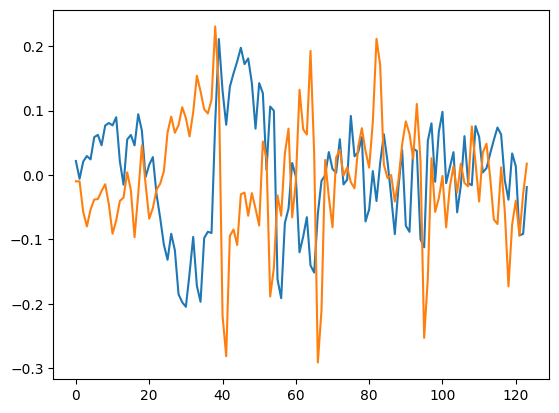

In [4]:
import matplotlib.pyplot as plt

plt.plot(ts[0][1,0])
plt.plot(ts[0][1,100])
plt.show()

In [52]:
import itertools

import torch
import torch.nn as nn
import torch.nn.functional as F

class LowRankCodes(nn.Module):
    '''
    ranks: array of rank for each codebook matrix
    '''
    def __init__(self, ranks):
        super(LowRankCodes, self).__init__()
        self.As = []
        for rank in ranks:
            A = nn.Parameter(1e-2*torch.randn(rank,264).float().cuda())
            self.As.append(A)
        self.As = nn.ParameterList(self.As)

    def forward(self):
        book = []
        for A in self.As:
            AA = A.T@A
            book.append(AA)
        return torch.stack(book)
    
class LowRankWeights(nn.Module):
    '''
    For a single modality!
    
    nsubs: number of subjects
    ncodes: number of pages in the codebook
    nt: number of timepoints
    '''
    def __init__(self, nsubs, ncodes, nt):
        super(LowRankWeights, self).__init__()
        self.w = nn.Parameter(1e-2*torch.rand(nsubs, ncodes, nt).float().cuda())

    def forward(self, sub, book):
        w = F.relu(self.w[sub])
        return torch.einsum('pt,pab->abt', w, book)
    
def get_recon_loss(x, xhat):
    return mseLoss(xhat, x)

def get_smooth_loss_fc(xhat):
    before = xhat[:,:,:-1]
    after = xhat[:,:,1:]
    return torch.mean((before-after)**2)

def get_sub_fc(subts):
    return torch.einsum('at,bt->abt',subts,subts)
    
# Timeseries
x = torch.from_numpy(ts[0]).float().cuda()
    
# Parameters
ntrain = 400
nbatch = 30
smooth_mult = 0.1
sparse_mult = 0
nEpochs = 50
pPeriod = 40

mseLoss = nn.MSELoss()
    
# Codebook and weights
lrc = LowRankCodes(500*[1])
ncodes = len(lrc.As)

lrw = LowRankWeights(ntrain, ncodes, x.shape[-1])

# Optimizers
optim = torch.optim.Adam(itertools.chain(lrc.parameters(), lrw.parameters()), lr=1e-2, weight_decay=0)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=int(ntrain/nbatch)+5, factor=0.75, eps=1e-7)
    
for epoch in range(nEpochs):
    suborder = np.arange(ntrain)
#     np.random.shuffle(suborder)
    for bstart in range(0,ntrain,nbatch):
        bend = bstart+nbatch
        if bend > ntrain:
            bend = ntrain
        optim.zero_grad()
        book = lrc()
        recon_loss = 0
        smooth_loss_fc = 0
        for subidx in range(bstart, bend):
            sub = suborder[subidx]
            xsub = get_sub_fc(x[sub])
            xhat = lrw(sub, book)
            recon_loss += get_recon_loss(xsub, xhat)
            smooth_loss_fc += smooth_mult*get_smooth_loss_fc(xhat)
        recon_loss /= (bend-bstart)
        smooth_loss_fc /= (bend-bstart)
        sparse_loss = sparse_mult*torch.mean(torch.abs(lrw.w))
#         sparse_loss = sparse_mult*torch.mean(lrw.w*torch.log(lrw.w))
        totloss = recon_loss+smooth_loss_fc+sparse_loss
        totloss.backward()
        optim.step()
        sched.step(totloss)
        if bstart % nbatch == 0:
            print(f'{epoch} {bstart} recon: {[float(ls)**0.5 for ls in [recon_loss, smooth_loss_fc, sparse_loss]]} '
                  f'lr: {sched._last_lr}')

print('Complete')

0 0 recon: [0.011948547108987583, 2.885728358103455e-06, 0.0] lr: [0.01]
0 30 recon: [0.011827329072831978, 2.90172705292115e-06, 0.0] lr: [0.01]
0 60 recon: [0.012338202370469856, 2.9147541480755097e-06, 0.0] lr: [0.01]
0 90 recon: [0.012015887662203361, 2.9307851347199878e-06, 0.0] lr: [0.01]
0 120 recon: [0.013904322450601971, 2.9486140429050343e-06, 0.0] lr: [0.01]
0 150 recon: [0.012889058792811667, 2.9719305957827804e-06, 0.0] lr: [0.01]
0 180 recon: [0.011780830816198382, 3.0047583976239183e-06, 0.0] lr: [0.01]
0 210 recon: [0.012281285584565958, 3.036809147999573e-06, 0.0] lr: [0.01]
0 240 recon: [0.012491643103298413, 3.071104926138756e-06, 0.0] lr: [0.01]
0 270 recon: [0.01284152380123544, 3.1182230572989198e-06, 0.0] lr: [0.01]
0 300 recon: [0.011859423240634498, 3.1804064580310103e-06, 0.0] lr: [0.01]
0 330 recon: [0.01253999148939027, 3.2533912973868215e-06, 0.0] lr: [0.01]
0 360 recon: [0.011995376056622271, 3.3381216418664168e-06, 0.0] lr: [0.01]
0 390 recon: [0.01478852

7 360 recon: [0.009912662053203214, 0.002349378372123639, 0.0] lr: [0.0075]
7 390 recon: [0.010716791979683636, 0.0037055639907963124, 0.0] lr: [0.0075]
8 0 recon: [0.009530353312812875, 0.0019070921367795213, 0.0] lr: [0.0075]
8 30 recon: [0.009252284189144025, 0.0017555076497053385, 0.0] lr: [0.0075]
8 60 recon: [0.010088895306752504, 0.0015414029426629554, 0.0] lr: [0.0075]
8 90 recon: [0.009836902744723538, 0.0013299960274945725, 0.0] lr: [0.0075]
8 120 recon: [0.011629387881955437, 0.0014291202614860159, 0.0] lr: [0.0075]
8 150 recon: [0.010600164458665174, 0.001183408576083187, 0.0] lr: [0.0075]
8 180 recon: [0.009615809555500773, 0.0011009190037908159, 0.0] lr: [0.0075]
8 210 recon: [0.010368852764430964, 0.0010089999898514192, 0.0] lr: [0.0075]
8 240 recon: [0.010755604390126001, 0.000968799396454265, 0.0] lr: [0.0075]
8 270 recon: [0.010752559458213308, 0.0011146925571970678, 0.0] lr: [0.0075]
8 300 recon: [0.010132652775457609, 0.0010501106192085275, 0.0] lr: [0.0075]
8 330 r

15 210 recon: [0.009153762533764131, 0.0019613240347807178, 0.0] lr: [0.0075]
15 240 recon: [0.009542171459262986, 0.001934746893747168, 0.0] lr: [0.0075]
15 270 recon: [0.009258657698035848, 0.002191062227811096, 0.0] lr: [0.0075]
15 300 recon: [0.008976127762762675, 0.0017970358469892238, 0.0] lr: [0.0075]
15 330 recon: [0.008591950377823917, 0.0021673884922796924, 0.0] lr: [0.0075]
15 360 recon: [0.009009259862279633, 0.0018175565749491934, 0.0] lr: [0.0075]
15 390 recon: [0.009564378371135482, 0.0028100181632816365, 0.0] lr: [0.0075]
16 0 recon: [0.008873745548725566, 0.0017964094288266772, 0.0] lr: [0.0075]
16 30 recon: [0.008645849144333603, 0.0018123917365548683, 0.0] lr: [0.0075]
16 60 recon: [0.009241686941375414, 0.0019018638547951482, 0.0] lr: [0.0075]
16 90 recon: [0.008880159687536388, 0.002017079909351144, 0.0] lr: [0.0075]
16 120 recon: [0.01031323459713177, 0.002328630539461599, 0.0] lr: [0.0075]
16 150 recon: [0.00914264523283507, 0.0022360396807583334, 0.0] lr: [0.007

23 0 recon: [0.008455631232311921, 0.0021525710637765967, 0.0] lr: [0.005625]
23 30 recon: [0.008252881758963392, 0.002160590469665974, 0.0] lr: [0.005625]
23 60 recon: [0.008825416102517372, 0.0022417037322490833, 0.0] lr: [0.005625]
23 90 recon: [0.008508457992392918, 0.00224841396625706, 0.0] lr: [0.005625]
23 120 recon: [0.009499622197637426, 0.002613170997635495, 0.0] lr: [0.005625]
23 150 recon: [0.008763629155408757, 0.002373646424901127, 0.0] lr: [0.005625]
23 180 recon: [0.008093653625533333, 0.002076996913561514, 0.0] lr: [0.005625]
23 210 recon: [0.008668480496827915, 0.002079168366167047, 0.0] lr: [0.005625]
23 240 recon: [0.00897952754312953, 0.0021583663022228896, 0.0] lr: [0.005625]
23 270 recon: [0.008804401450230238, 0.0024343818888594797, 0.0] lr: [0.005625]
23 300 recon: [0.008504612395485653, 0.00208722534356439, 0.0] lr: [0.005625]
23 330 recon: [0.0081822166295604, 0.002424778604614416, 0.0] lr: [0.005625]
23 360 recon: [0.008580472341498474, 0.002153569130959472,

30 180 recon: [0.007909516982749765, 0.0021378581198455864, 0.0] lr: [0.005625]
30 210 recon: [0.008423610839621832, 0.0021632688756593483, 0.0] lr: [0.005625]
30 240 recon: [0.008648475238676574, 0.0022725860860571888, 0.0] lr: [0.005625]
30 270 recon: [0.00860004822474725, 0.0024982336514108544, 0.0] lr: [0.005625]
30 300 recon: [0.008289158973235808, 0.0021647515257564366, 0.0] lr: [0.005625]
30 330 recon: [0.008018833465344571, 0.0024629798282111677, 0.0] lr: [0.005625]
30 360 recon: [0.008403906645897399, 0.0022137747306541595, 0.0] lr: [0.005625]
30 390 recon: [0.00822982455665788, 0.003423489030721098, 0.0] lr: [0.005625]
31 0 recon: [0.008256012261035242, 0.0022197986102348247, 0.0] lr: [0.005625]
31 30 recon: [0.008074816247096843, 0.0022143728246739438, 0.0] lr: [0.005625]
31 60 recon: [0.008593251863450444, 0.0023057030710369433, 0.0] lr: [0.005625]
31 90 recon: [0.008301967998828397, 0.0023080229721965523, 0.0] lr: [0.005625]
31 120 recon: [0.008866903363782045, 0.002878830

37 360 recon: [0.008276721766002217, 0.00225553209950497, 0.0] lr: [0.005625]
37 390 recon: [0.007958047320194927, 0.00347992059902823, 0.0] lr: [0.005625]
38 0 recon: [0.008143130079416075, 0.0022574747232416664, 0.0] lr: [0.005625]
38 30 recon: [0.007971531264141789, 0.002246673010586631, 0.0] lr: [0.005625]
38 60 recon: [0.008454639033015573, 0.002348899163707987, 0.0] lr: [0.005625]
38 90 recon: [0.008176085242788459, 0.002342224412321638, 0.0] lr: [0.005625]
38 120 recon: [0.008606791033137386, 0.002992904728277482, 0.0] lr: [0.005625]
38 150 recon: [0.008347855960350738, 0.002502568608051679, 0.0] lr: [0.005625]
38 180 recon: [0.007775053277266887, 0.0021798150560357853, 0.0] lr: [0.005625]
38 210 recon: [0.008227371265754813, 0.002233876080272701, 0.0] lr: [0.005625]
38 240 recon: [0.008389642023618714, 0.002358393296593785, 0.0] lr: [0.005625]
38 270 recon: [0.00844542960241014, 0.0025462485423765812, 0.0] lr: [0.005625]
38 300 recon: [0.00811510341084727, 0.0022259684006542477

45 120 recon: [0.008440842884479164, 0.003044035648423836, 0.0] lr: [0.005625]
45 150 recon: [0.008229014242487507, 0.0025351460871523538, 0.0] lr: [0.005625]
45 180 recon: [0.007689479975490597, 0.0022044006993060298, 0.0] lr: [0.005625]
45 210 recon: [0.008097635086528073, 0.0022803782773626598, 0.0] lr: [0.005625]
45 240 recon: [0.008229208318450499, 0.002410200573863197, 0.0] lr: [0.005625]
45 270 recon: [0.008345914690406903, 0.002577450710195087, 0.0] lr: [0.005625]
45 300 recon: [0.008000439718504756, 0.0022660664395419985, 0.0] lr: [0.005625]
45 330 recon: [0.007810567965253075, 0.0025188983248283095, 0.0] lr: [0.005625]
45 360 recon: [0.00816298465637977, 0.0022924618728506056, 0.0] lr: [0.005625]
45 390 recon: [0.007755013792979809, 0.0035273035366770356, 0.0] lr: [0.005625]
46 0 recon: [0.008049738882719792, 0.002286883768423684, 0.0] lr: [0.005625]
46 30 recon: [0.00788882484282414, 0.0022740516554100683, 0.0] lr: [0.005625]
46 60 recon: [0.008342870249951746, 0.00238273547

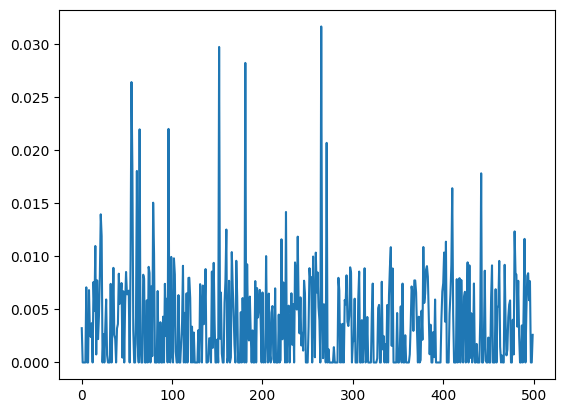

In [65]:
import matplotlib.pyplot as plt

plt.plot(F.relu(lrw.w[0,:,10]).detach().cpu().numpy())
plt.show()

In [55]:
# Elastic net attempt
# Keep the Lagrangian form of lstsqs to reduce data size

class ElasticNet(nn.Module):
    def __init__(self, AA, AB, l1, l2):
        super(ElasticNet, self).__init__()
        self.AA = AA
        self.AB = AB
        self.w = nn.Parameter(torch.rand(AB.shape[0],AA.shape[1],AB.shape[-1]).float().cuda())
        self.l1 = l1
        self.l2 = l2
        
    def train(self, lr=1e-1, nepochs=2000, pperiod=100, verbose=True):
        mseLoss = nn.MSELoss()
        optim = torch.optim.Adam([self.w], lr=lr, weight_decay=self.l2)
        sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=10, factor=0.75, eps=1e-7)
        for epoch in range(nepochs):
            optim.zero_grad()
            ABhat = torch.matmul(self.AA.detach(),F.relu(self.w))
            loss = mseLoss(ABhat, self.AB.detach())**0.5
            l1loss = self.l1*torch.mean(torch.abs(self.w))
            totloss = loss+l1loss
            totloss.backward()
            optim.step()
            sched.step(totloss)
            if not verbose:
                continue
            if epoch % pperiod == 0 or epoch == nepochs-1:
                print(f'{epoch} {[float(ls) for ls in [loss, l1loss]]} {sched._last_lr}')
        if verbose:
            print('Complete')

book = lrc()

A = book.reshape(book.shape[0], -1).permute(1,0).detach()
AA = A.T@A
AB = []

for sub in range(x.shape[0]):
    B = get_sub_fc(x[sub]).reshape(-1, x.shape[-1])
    AB.append(A.T@B)

AB = torch.stack(AB)
net = ElasticNet(AA.unsqueeze(0), AB, 0, 1e-4)
net.train(nepochs=500, lr=1e-1)

0 [411.2328796386719, 0.0] [0.1]
100 [0.39937707781791687, 0.0] [0.0421875]
200 [0.3279531002044678, 0.0] [0.013348388671875001]
300 [0.32693079113960266, 0.0] [0.0031676352024078373]
400 [0.32692471146583557, 0.0] [0.0002378408954200495]
499 [0.32692447304725647, 0.0] [1.7858209017001475e-05]
Complete


In [56]:
# Fast weight estimation for all subjects

book = lrc()

A = book.reshape(book.shape[0], -1).permute(1,0)
AA = A.T@A
codes = []

for sub in range(x.shape[0]):
    B = get_sub_fc(x[sub]).reshape(-1, x.shape[-1])
    AB = A.T@B
    C,_,_,_ = torch.linalg.lstsq(AA+0.1*torch.eye(AA.shape[0]).float().cuda(),AB)
    codes.append(torch.from_numpy(C.detach().cpu().numpy()))
    if sub % 100 == 0:
        loss = mseLoss(A@C,B)**0.5
        print(f'Finished {sub} {loss}')
    
codes = torch.stack(codes)
print(codes.shape)

Finished 0 0.007119395770132542
Finished 100 0.007877778261899948
Finished 200 0.005846417974680662
Finished 300 0.007364880293607712
Finished 400 0.007187970448285341
Finished 500 0.006694667972624302
Finished 600 0.008519605733454227
Finished 700 0.006978908553719521
Finished 800 0.007500973995774984
torch.Size([847, 500, 124])


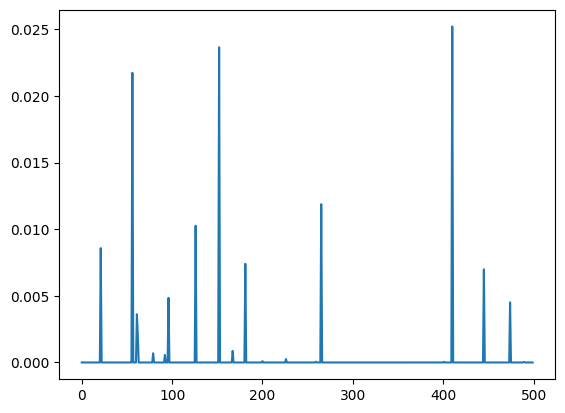

In [64]:
import matplotlib.pyplot as plt

# plt.plot(codes[0,:,10].detach().cpu().numpy())
plt.plot(F.relu(net.w[0,:,10]).detach().cpu().numpy())
# plt.plot(F.relu(lrw.w[0,:,10]).detach().cpu().numpy(), linestyle='dotted')
plt.show()

0.000757521322235249
0.1627847442065422
0.1585849648452618


/tmp/ipykernel_827579/11023820.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


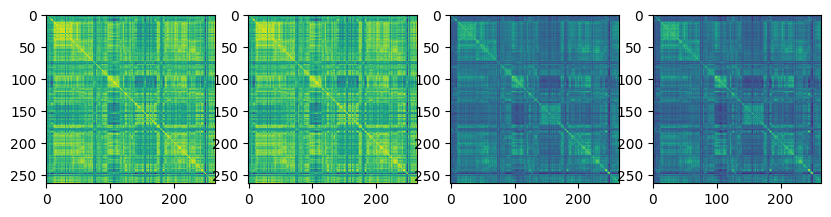

In [29]:
# Reconstruct static FC from dynamic FC

import matplotlib.pyplot as plt

sub = 200

dynfc = get_sub_fc(x[sub])
dynfc = torch.mean(dynfc, dim=-1).detach().cpu().numpy()

statfc = np.corrcoef(ts[0][sub])

reconfc = lrw(sub, book)
reconfc = torch.mean(reconfc, dim=-1).detach().cpu().numpy()

A = book.reshape(book.shape[0], -1).permute(1,0)
reconfc2 = torch.mean(A.cpu()@F.relu(net.w[sub]).detach().cpu(), dim=1).reshape(264,264).detach().cpu().numpy()

fig, ax = plt.subplots(1,4,figsize=(10,3))

print(np.mean((statfc-124*dynfc)**2)**0.5)
print(np.mean((statfc-124*reconfc)**2)**0.5)
print(np.mean((statfc-124*reconfc2)**2)**0.5)

ax[0].imshow(dynfc)
ax[1].imshow(statfc)
ax[2].imshow(reconfc)
ax[3].imshow(reconfc2)
fig.show()

In [72]:
ntrain = 30

losses = []

for ntrain in [30,50,100,200,300,400,500,600,700,800]:

    codescuda = codes.float().cuda()
#     codescuda = F.relu(net.w.detach())
    xps = torch.mean(codescuda, dim=-1) #ps.reshape(ps.shape[0],-1)
    xps = torch.cat([xps, torch.ones(xps.shape[0], 1).float().cuda()], dim=1)
    xtr = xps[:ntrain]
    xt = xps[ntrain:]

    y = get_y(metadict, ['age'], subs)[0]
    y_t = torch.from_numpy(y).float().cuda()
    ytr = y_t[:ntrain]
    yt = y_t[ntrain:]

    # REDUCE THIS TO GET GOOD RESULTS WITH SPARSITY 0.01->0.001 or 0.0001
    w, _, _, _ = torch.linalg.lstsq(xtr.T@xtr + 0.01*torch.eye(501).float().cuda(), xtr.T@ytr)

#     print(torch.mean((ytr-xtr@w)**2)**0.5)
    losses.append(float(torch.mean((yt-xt@w)**2)**0.5))
    
print(losses)

[38.53715515136719, 38.266639709472656, 36.137107849121094, 33.635337829589844, 32.772560119628906, 31.699859619140625, 29.590267181396484, 30.42137336730957, 30.020339965820312, 27.58401107788086]


In [76]:
import itertools

import torch
import torch.nn as nn
import torch.nn.functional as F
    
class CNN(nn.Module):
    def __init__(self, x, dp=0.1):
        super(CNN, self).__init__()
        self.cnn1 = torch.nn.Conv2d(1,10,(x.shape[-2],4)).float().cuda()
        self.ap1 = torch.nn.AvgPool2d((1,x.shape[-1]-3))
        self.lin1 = torch.nn.Linear(10,1).float().cuda()
        self.dp = nn.Dropout(p=dp)
        
    def forward(self, ts):
        ts = self.dp(ts)
        y = F.relu(self.cnn1(ts))
        y = self.ap1(y)
        z = y.reshape(y.shape[0], -1).squeeze()
        y = self.lin1(z)
        return z, y.squeeze()
    
nEpochs = 1000
pPeriod = 200

ntrain = 30

losses = []

for ntrain in [30,50,100,200,300,400,500,600,700,800]:

#     codescuda = F.relu(net.w.detach()) 
    codescuda = codes.float().cuda()
    xps = codescuda.unsqueeze(1)
    xtr = xps[:ntrain]
    xt = xps[ntrain:]

    y = get_y(metadict, ['age'], subs)[0]
    y_t = torch.from_numpy(y).float().cuda()
    ytr = y_t[:ntrain]
    yt = y_t[ntrain:]

    cnn = CNN(xtr, dp=0)

    optim = torch.optim.Adam(cnn.parameters(), lr=1e-1, weight_decay=1e-1)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=10, factor=0.9, eps=1e-7)

    for epoch in range(nEpochs):
        optim.zero_grad()
        z, yhat1 = cnn(xtr)
        loss = mseLoss(yhat1, ytr)
        loss.backward()
        optim.step()
        sched.step(loss)
        if epoch % pPeriod == 0 or epoch == nEpochs-1:
            print(f'{epoch} recon: {loss**0.5} {sched._last_lr}')

    print('Complete')

    cnn.eval()
    z, yhat1 = cnn(xt)
    loss = mseLoss(yhat1, yt)**0.5
    losses.append(float(loss))
    
    print(loss)
    
print(losses)

0 recon: 191.14111328125 [0.1]
200 recon: 9.353903770446777 [0.1]
400 recon: 6.034331798553467 [0.1]
600 recon: 4.454237937927246 [0.1]
800 recon: 3.6948440074920654 [0.07290000000000002]
999 recon: 3.338467597961426 [0.05904900000000002]
Complete
tensor(38.5908, device='cuda:0', grad_fn=<PowBackward0>)
0 recon: 186.96353149414062 [0.1]
200 recon: 12.78134822845459 [0.09000000000000001]
400 recon: 9.817344665527344 [0.09000000000000001]
600 recon: 7.670979976654053 [0.09000000000000001]
800 recon: 6.270430564880371 [0.09000000000000001]
999 recon: 5.3468475341796875 [0.09000000000000001]
Complete
tensor(37.8277, device='cuda:0', grad_fn=<PowBackward0>)
0 recon: 182.5110321044922 [0.1]
200 recon: 20.353656768798828 [0.09000000000000001]
400 recon: 16.502025604248047 [0.09000000000000001]
600 recon: 13.437162399291992 [0.09000000000000001]
800 recon: 11.315217018127441 [0.09000000000000001]
999 recon: 9.84438705444336 [0.08100000000000002]
Complete
tensor(36.6817, device='cuda:0', grad_f

KeyboardInterrupt: 

In [77]:
import sys

sys.path.append('../../LatentSimilarity')

from latsim import LatSim

print('Complete')

Complete


In [79]:
ntrain = 800

losses = []

for ntrain in [30,50,100,200,300,400,500,600,700,800]:
    codescuda = codes.float().cuda()
    xps = codescuda.unsqueeze(1)
    xtr = xps[:ntrain]
    xt = xps[ntrain:]

    y = get_y(metadict, ['age'], subs)[0]
    y_t = torch.from_numpy(y).float().cuda()
    ytr = y_t[:ntrain]
    yt = y_t[ntrain:]

    mseLoss = nn.MSELoss()

    nEpochs = 500
    pPeriod = 100

    cnn = CNN(xtr, dp=0.1)
    sim = LatSim(1, torch.zeros(1,1,10), dp=0, edp=0.1, wInit=1e-4, dim=20, temp=1)

    optim = torch.optim.Adam(itertools.chain(cnn.parameters(), sim.parameters()), lr=1e-1, weight_decay=1e-2)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=10, factor=0.9, eps=1e-7)

    for epoch in range(nEpochs):
        optim.zero_grad()
        z, yhat1 = cnn(xtr)
        yhat2 = sim(z.unsqueeze(1), [ytr])[0][0]
        loss = mseLoss(yhat2, ytr)
        loss.backward()
        optim.step()
        sched.step(loss)
        if epoch % pPeriod == 0 or epoch == nEpochs-1:
            print(f'{epoch} recon: {loss**0.5} {sched._last_lr}')

    print('Complete')

    cnn.eval()
    sim.eval()
    z, yhat1 = cnn(xps)
    yhat2 = sim(z.unsqueeze(1), [y_t])[0][0][ntrain:]
    loss = mseLoss(yhat2, yt)**0.5
    losses.append(float(loss))
    
    print(float(loss))
    
print(losses)

0 recon: 39.34846878051758 [0.1]
100 recon: 6.653782367706299 [0.07290000000000002]
200 recon: 5.5418782234191895 [0.03138105960900001]
300 recon: 6.603857517242432 [0.01215766545905694]
400 recon: 5.476126194000244 [0.00471012869724625]
499 recon: 6.494833946228027 [0.0018248003631400759]
Complete
38.64051818847656
0 recon: 35.32155227661133 [0.1]
100 recon: 5.833658218383789 [0.1]
200 recon: 3.452425718307495 [0.04782969000000002]
300 recon: 3.4900293350219727 [0.01853020188851842]
400 recon: 3.4938457012176514 [0.009847709021836121]
499 recon: 2.936023712158203 [0.004239115827521626]
Complete
37.8840217590332
0 recon: 37.065433502197266 [0.1]
100 recon: 4.202347278594971 [0.09000000000000001]
200 recon: 4.340254783630371 [0.04782969000000002]
300 recon: 3.6471965312957764 [0.01853020188851842]
400 recon: 3.6380465030670166 [0.00886293811965251]
499 recon: 3.522996425628662 [0.003433683820292517]
Complete
37.18783950805664
0 recon: 39.9236946105957 [0.1]
100 recon: 5.171610355377197 

In [84]:
ntrain = 700

losses = []

for ntrain in [30,50,100,200,300,400,500,600,700,800]:
    codescuda = codes.float().cuda()
#     codescuda = F.relu(net.w.detach())
    xps = torch.mean(codescuda, dim=-1).unsqueeze(1)
    xtr = xps[:ntrain]
    xt = xps[ntrain:]

    y = get_y(metadict, ['age'], subs)[0]
    y_t = torch.from_numpy(y).float().cuda()
    ytr = y_t[:ntrain]
    yt = y_t[ntrain:]

    mseLoss = nn.MSELoss()

    nEpochs = 500
    pPeriod = 100

    sim = LatSim(1, torch.zeros(1,1,ncodes), dp=0.1, edp=0.1, wInit=1e-2, dim=2, temp=1)

    optim = torch.optim.Adam(sim.parameters(), lr=1e-1, weight_decay=1e-3)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=10, factor=0.9, eps=1e-7)

    for epoch in range(nEpochs):
        optim.zero_grad()
        yhat = sim(xtr, [ytr])[0][0]
        loss = mseLoss(yhat, ytr)
        loss.backward()
        optim.step()
        sched.step(loss)
        if epoch % pPeriod == 0 or epoch == nEpochs-1:
            print(f'{epoch} recon: {loss**0.5} {sched._last_lr}')

    print('Complete')

    sim.eval()
    yhat = sim(xps, [y_t])[0][0][ntrain:]
    loss = mseLoss(yhat, yt)**0.5
    losses.append(float(loss))
    
    print(loss)
print(losses)

0 recon: 38.566287994384766 [0.1]
100 recon: 8.615525245666504 [0.07290000000000002]
200 recon: 7.691046237945557 [0.028242953648100012]
300 recon: 8.757450103759766 [0.01215766545905694]
400 recon: 8.350165367126465 [0.00471012869724625]
499 recon: 10.714152336120605 [0.0018248003631400759]
Complete
tensor(38.5266, device='cuda:0', grad_fn=<PowBackward0>)
0 recon: 35.153564453125 [0.1]
100 recon: 7.292947769165039 [0.09000000000000001]
200 recon: 7.1689324378967285 [0.03874204890000002]
300 recon: 7.4608635902404785 [0.015009463529699923]
400 recon: 6.872679233551025 [0.006461081889226681]
499 recon: 6.790865898132324 [0.002503155504993245]
Complete
tensor(38.2750, device='cuda:0', grad_fn=<PowBackward0>)
0 recon: 37.1037712097168 [0.1]
100 recon: 10.341070175170898 [0.1]
200 recon: 9.431367874145508 [0.05314410000000002]
300 recon: 9.42437744140625 [0.025418658283290013]
400 recon: 8.87295913696289 [0.00886293811965251]
499 recon: 9.26282787322998 [0.0038152042447694634]
Complete
ten